In [1]:
# import packages
import pandas as pd
import os
import glob
import random
import numpy as np
import statistics
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.patches as mpatches

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import norm

## Dataset Prep

In [2]:
# import word count .csv file from local path
path = r'/Users/spencersu/Desktop/Rockdale'
wordcount = pd.read_csv(os.path.join(path, 'Rockdale word count 19-22.csv'))

# remove column: the first column "Unnamed: 0"
wordcount = wordcount.iloc[:,1:17]

# now 239253 rows × 16 columns

## change data type into integer: 'Word Count' column
# drop nan for Word Count column
wordcount = wordcount.dropna(subset=['Word Count'])

# replace ',' with ''
wordcount['Word Count'].replace(',','',regex=True,inplace=True)

# convert data type of word count column into integer
wordcount['Word Count'] = wordcount['Word Count'].astype(int)


##  create a function for repeated group by. 
def groupby_wc(df_togroup, groups):
    df = df_togroup.groupby(groups)['Word Count'].mean()
    df = pd.DataFrame(df)
    df = df.reset_index()
    return df
    
# create a subset for only teacher and student assignment ID
# because some assignments have a null value for teacher name, if groupby teacher, will reduce the number of assignments 
group1 = ['Teacher Name [Sensitive]','Student Assignment ID']
wc_teacher = groupby_wc(wordcount, group1)

wc_teacher.drop(['Word Count'],axis=1,inplace=True)


# remove rubric categories
    
group2 = ['School Year', 'School Name', 'Student ID','Full Name',
           'Enrolled Grade','Lesson ID', 'Writing Lesson Category','Student Assignment ID']
wordcount = groupby_wc(wordcount,group2)


# add teacher name back to df wordcount 
wordcount = pd.merge(wordcount, wc_teacher, on='Student Assignment ID',how='left')


# wordcnt dataset now has 34664 rows × 10 columns
# data retrieved on Jan 20, 2022

## Data Overview

In [3]:
# count unique number of student assignments and students
print(wordcount.groupby('School Year')['Student Assignment ID','Full Name'].nunique())
print(wordcount.groupby(['School Year','Enrolled Grade'])['Student Assignment ID','Full Name'].nunique())

             Student Assignment ID  Full Name
School Year                                  
2019-2020                     6374       3761
2020-2021                    12648       5429
2021-2022                    15642       5755
                            Student Assignment ID  Full Name
School Year Enrolled Grade                                  
2019-2020   3                                  68         40
            4                                 288        151
            5                                1443        716
            6                                1095        628
            7                                 985        627
            8                                2495       1614
2020-2021   3                                 125         55
            4                                2063        811
            5                                2165        851
            6                                1606        735
            7                         

In [4]:
# remove outliers for word count
z = np.abs(stats.zscore(wordcount['Word Count']))
# threshold = 3
wordcount['z'] = z
wordcount = wordcount[wordcount['z']<3]

# 34285 rows × 11 columns

In [5]:
# word count overview by grades
wordcount.groupby(['School Year','Enrolled Grade'])['Word Count'].mean()

School Year  Enrolled Grade
2019-2020    3                 113.235294
             4                 107.689895
             5                 120.562196
             6                 153.843693
             7                 208.227088
             8                 289.865182
2020-2021    3                  89.824000
             4                 101.498544
             5                 137.348169
             6                 167.879526
             7                 185.377514
             8                 287.795662
2021-2022    3                 100.781506
             4                 159.762910
             5                 189.893045
             6                 256.756057
             7                 294.401267
             8                 343.353303
Name: Word Count, dtype: float64

In [6]:
# wordcount.to_csv(os.path.join(path, 'Avg Word Count For Threshold Graphs.csv'))

## Box plots (just for viewing the structure)

<Figure size 720x576 with 0 Axes>

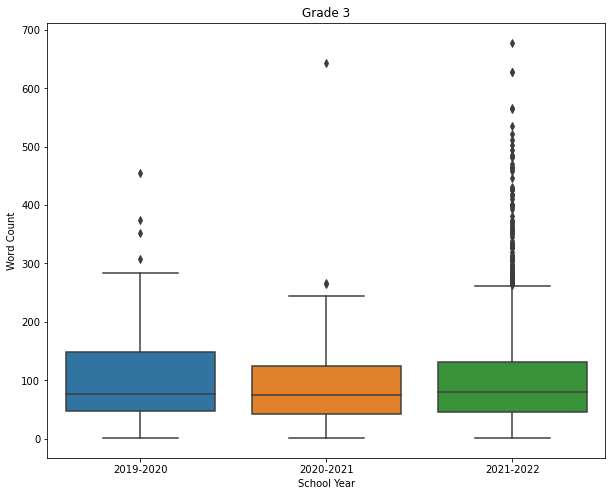

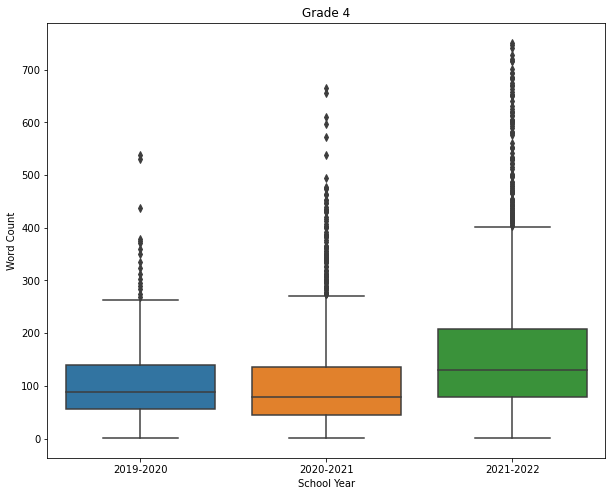

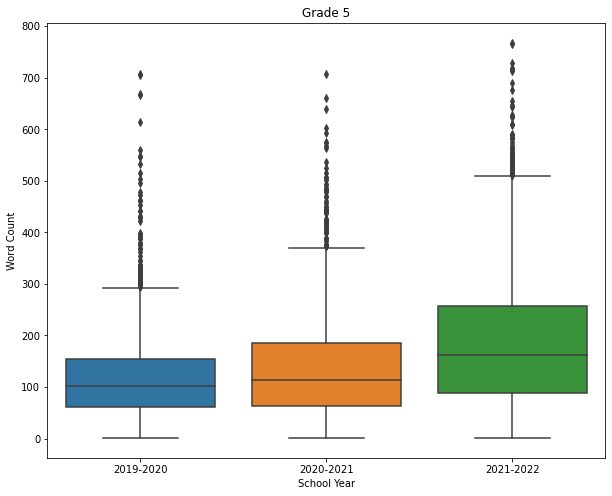

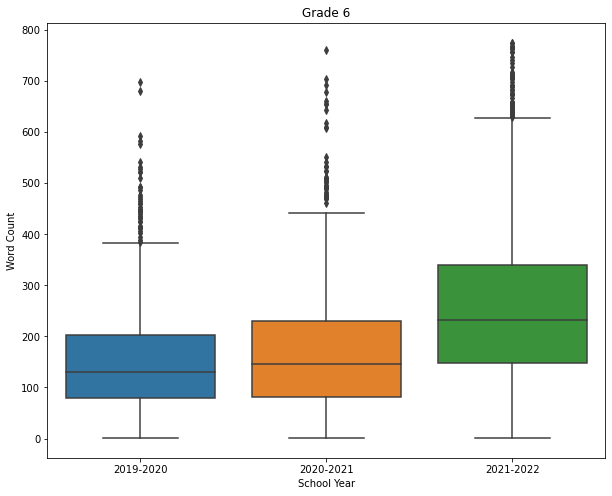

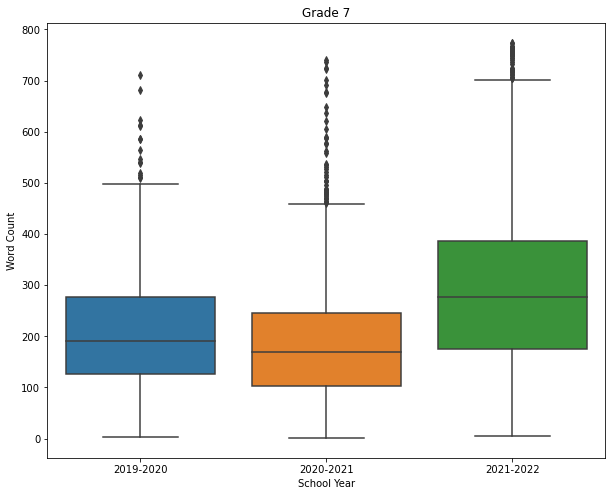

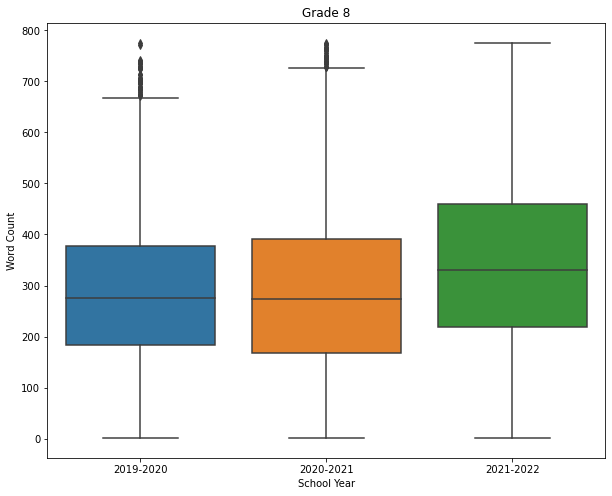

In [7]:
# boxplot: word count by school year (for each grade)
plt.figure(figsize = (10,8))

for n in range(3,9): 
    plt.figure(figsize = (10,8))
    # choose the grade  
    grade = wordcount[wordcount['Enrolled Grade']==n] 
    
    ax = sns.boxplot(x=grade['School Year'],y=grade['Word Count'])
    ax.set_title('Grade %d' %n)
    plt.savefig('/Users/spencersu/Desktop/JCPS Efficacy Report/Datasets/boxplot grade' + str(n) +'.png')
    plt.show()

## t-test

In [8]:
# drop column enrolled grade
group3 = ['School Year','School Name','Full Name']
pvt = groupby_wc(wordcount,group3)

# reshape, pivot
pvt = pvt.pivot(index=['School Name','Full Name'], columns='School Year', values='Word Count')

# drop all rows that include nan 
pvt = pvt.dropna()

print(ttest_rel(pvt['2019-2020'], pvt['2020-2021']))
print(ttest_rel(pvt['2020-2021'], pvt['2021-2022']))
print(ttest_rel(pvt['2019-2020'], pvt['2021-2022']))

## t-test results have shown that there is a difference between each year, and the word count improves year by year

Ttest_relResult(statistic=-4.939293515992085, pvalue=1.0004116714275427e-06)
Ttest_relResult(statistic=-18.600053515602333, pvalue=3.9488147491230554e-62)
Ttest_relResult(statistic=-21.599841741137137, pvalue=3.036001810950753e-78)


## Scatterplot (usage vs. word count)

In [9]:
## create a dataset for the number of assignments for each students, each school year

# subsets
wc_asgmt_a = wordcount.groupby(['School Year','School Name','Full Name'])['Word Count'].mean()
wc_asgmt_b = wordcount.groupby(['School Year','School Name','Full Name'])['Student Assignment ID'].count()

# merge
wc_asgmt = pd.merge(wc_asgmt_a,wc_asgmt_b,on=['School Year','School Name','Full Name'], how='inner')
wc_asgmt = wc_asgmt.reset_index()
wc_asgmt.rename(columns={wc_asgmt.columns[4]: 'num_asgmt'}, inplace = True)

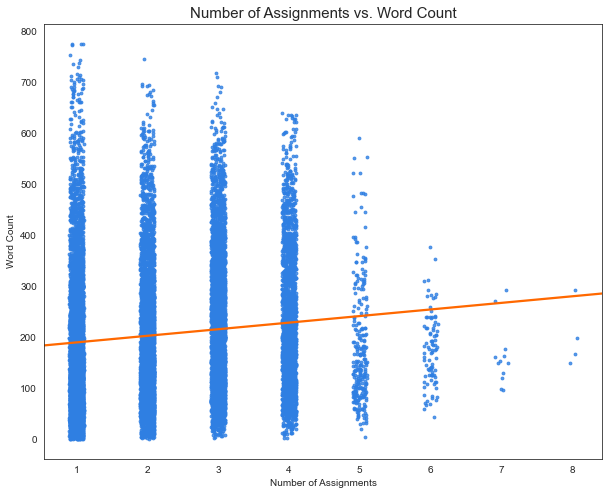

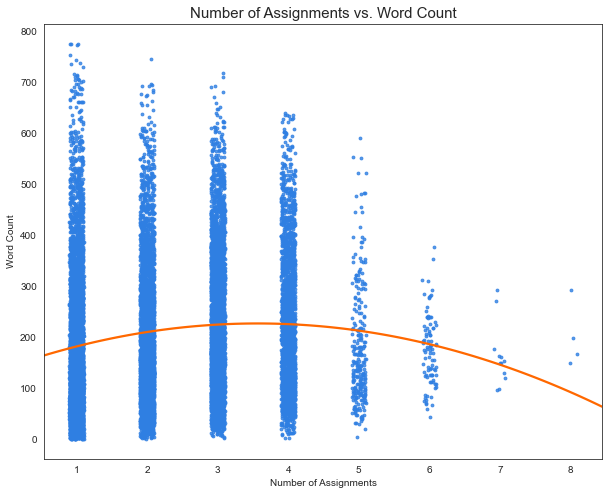

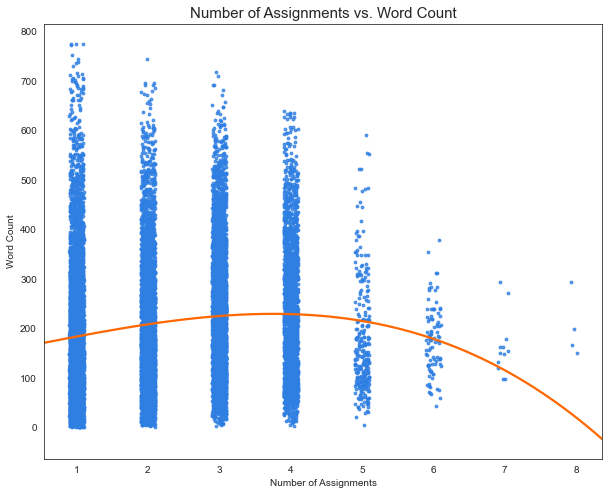

In [10]:
for n in range (1,4):
    sns.set_style(style='white')
    plt.figure(figsize = (10,8))
    sns.regplot(wc_asgmt['num_asgmt'],wc_asgmt['Word Count'], order = n,
                scatter_kws={"color": "#2f7fe2",'s':8}, truncate = False, x_jitter=.1,marker='o',
                line_kws={"color": "#ff6800"}, ci=None)
    plt.xlabel('Number of Assignments')
    plt.ylabel('Word Count')
    plt.title("Number of Assignments vs. Word Count", fontsize=15)
    plt.savefig(os.path.join(path,'The Number of Assignments vs. Word Count (Order ' + str(n) +').png'))
    plt.show()

<Figure size 720x576 with 0 Axes>

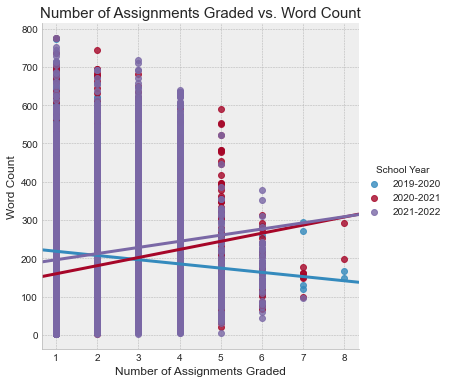

In [40]:
plt.style.use('bmh')
plt.figure(figsize = (10,8))
sns.lmplot(x='num_asgmt',y='Word Count', data=wc_asgmt,
           truncate = False, hue='School Year',ci=None)
plt.xlabel('Number of Assignments Graded')
plt.ylabel('Word Count')
plt.title("Number of Assignments Graded vs. Word Count", fontsize=15)
plt.show()

## Regression (usage vs. word count)

In [41]:
wc_reg_a = wordcount.groupby(['School Year','School Name','Full Name','Enrolled Grade'])['Word Count'].mean()
wc_reg_b = wordcount.groupby(['School Year','School Name','Full Name','Enrolled Grade'])['Student Assignment ID'].count()

wc_reg = pd.merge(wc_reg_a, wc_reg_b, on = ['School Year','School Name','Full Name','Enrolled Grade'], how = 'outer')

wc_reg = wc_reg.reset_index()

wc_reg.rename(columns={wc_reg.columns[0]: 'school_year', 
                       wc_reg.columns[1]: 'school_name',
                       wc_reg.columns[2]: 'student_name', 
                       wc_reg.columns[3]: 'enrolled_grade',
                       wc_reg.columns[4]: 'word_count',
                       wc_reg.columns[5]: 'num_asgmts'}, inplace = True)

In [43]:
results = smf.ols('word_count ~ num_asgmts + C(enrolled_grade) + C(school_year) + C(school_name)', data=wc_reg).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             word_count   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     381.8
Date:                Wed, 09 Feb 2022   Prob (F-statistic):               0.00
Time:                        22:37:33   Log-Likelihood:                -91668.
No. Observations:               15015   AIC:                         1.834e+05
Df Residuals:                   14990   BIC:                         1.836e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [45]:
results2 = smf.ols('word_count ~ num_asgmts^2 + C(enrolled_grade) + C(school_year) + C(school_name)', data=wc_reg).fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:             word_count   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     358.6
Date:                Wed, 09 Feb 2022   Prob (F-statistic):               0.00
Time:                        22:37:56   Log-Likelihood:                -91843.
No. Observations:               15015   AIC:                         1.837e+05
Df Residuals:                   14990   BIC:                         1.839e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [36]:
wc_reg = pd.get_dummies(wc_reg, columns=['enrolled_grade','school_name','school_year'])

Y = wc_reg['word_count']
X = wc_reg[wc_reg.columns.drop(['word_count','student_name'])]

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

# add constant does not work very well

                            OLS Regression Results                            
Dep. Variable:             word_count   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     381.8
Date:                Wed, 09 Feb 2022   Prob (F-statistic):               0.00
Time:                        22:27:43   Log-Likelihood:                -91668.
No. Observations:               15015   AIC:                         1.834e+05
Df Residuals:                   14990   BIC:                         1.836e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [32]:
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.0001
lasso_nalpha=20
lasso_iter=5000
# Min and max degree of polynomials features to consider
degree_min = 1
degree_max = 3 
# 1st degree has the highest RMSE, 2nd degree has the highest test score 

# Test/train split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)
    
    # Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
for degree in range(degree_min,degree_max+1):
    model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), 
                          LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,normalize=True,cv=5))
    model.fit(X_train,y_train)
    test_pred = np.array(model.predict(X_test))
    RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
    test_score = model.score(X_test,y_test)
    print("degree =", degree, ", and RMSE =", RMSE)
    print("degree =", degree, ", and test score =", test_score)

degree = 1 , and RMSE = 6122.3169770409295
degree = 1 , and test score = 0.3394501470616128
degree = 2 , and RMSE = 6011.417135095723
degree = 2 , and test score = 0.36316385022778275
degree = 3 , and RMSE = 5962.439567266515
degree = 3 , and test score = 0.37349872572999465


## Random Forest Regression

In [48]:
group4 = ['School Year','School Name','Lesson ID','Teacher Name [Sensitive]','Enrolled Grade',
          'Writing Lesson Category','Student Assignment ID']

wc_rf = groupby_wc(wordcount, group4)

# 17404 rows × 8 columns

wc_rf = pd.get_dummies(wc_rf)

In [49]:
Y_rf = wc_rf['Word Count']
X_rf = wc_rf[wc_rf.columns.drop(['Word Count'])]

X_train, X_test, y_train, y_test = train_test_split(X_rf,Y_rf,test_size=0.2)

model_rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=100)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)
print('Training RMSE:', np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print('Training R Squared:', r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)
print('Testing RMSE:', np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print('Testing R Squared:',r2_score(y_test, pred_test_rf))

# training set R Squared is good, but training set and testing set has a huge difference 

Training RMSE: 49.76684735240751
Training R Squared: 0.9049346791128061
Testing RMSE: 135.29655030873207
Testing R Squared: 0.27653510582601004
